todo :

- Remove noise
    1. explain
    2. explain
    3. explain
    4. explain

- DC
    - Watermark Insertion
        7. explain
        8. explain
    - Watermark Detection
        9. explain

- Morphology
    - Morphology
        0. explain
    - Granulometry
        0. all
- PCA
    - all

In [47]:
import warnings
import cv2
from matplotlib.pyplot import figure, title, subplot, axis, imshow, show, hist, plot, tight_layout
from numpy import sinc, mgrid, exp, abs, pi, zeros, uint8, conj, divide, double, r_, unravel_index, argpartition, c_, hstack, mean, sqrt, nan, sum
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from skimage.util import random_noise
from cv2 import cvtColor, COLOR_BGR2GRAY, getStructuringElement, MORPH_ELLIPSE, erode, dilate, countNonZero, subtract, connectedComponents
from numpy.random import normal
from scipy.fftpack import dct, idct

warnings.filterwarnings("ignore")

# Project 2
#### IIVP 21-22
#### Giuseppe Lorenzo Pompigna


In [48]:
figure_size = (18,7)
# functions to load/convert/display images, used throughout the whole assignment
def load(keyword, code=None):
    # read image by file
    # if code is 0 it reads the image with grayscale
    i =  cv2.imread('images/'+keyword+'.jpg', code)
    if i is None:
        i = cv2.imread('images/'+keyword+'.jpeg', code)
    if i is None:
        i = cv2.imread('images/'+keyword+'.tif', code)
    if i is None:
        print("Not found any ",keyword," jpg or jpeg")
    return i
def rgb(bgr):
    # convert bgr image to rgb
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
def gray(img):
    return cvtColor(img, COLOR_BGR2GRAY)
def binarize(img, threshold = 180):
    img = img.astype(int)
    m,n,_ = img.shape
    _gray = zeros((m,n), int)
    for i in range(0,m):
        for j in range(0,n):
            _gray[i,j] = 1 if img[i,j,0] > threshold else 0
    return _gray
def show_images(name,images,desc,col=None):
    figure(figsize=figure_size)
    n = len(images)
    for k in range(0,n):
        img = images[k].astype(uint8)
        tit = name + " " + desc[k]
        if not col is None:
            c = col[k]
            subplot(1,n,k+1), title(tit), axis('off'), imshow(img,cmap=c)
        else :
            subplot(1,n,k+1), title(tit), axis('off'), imshow(img)
    tight_layout()
    show()

# 1 Image degradation
With motion blur and additive noise

Choose one colored image and add **diagonal motion blur** and **additive noise** in the frequency domain

In [49]:
F = rgb(load("geese"))

#### Degrading the image and adding noise
Create a diagonal motion blurring function, apply it to the image in the frequency domain

$$ H(u,v) = sinc( \alpha \cdot u + \beta \cdot v) \cdot exp(-j \pi ( \alpha \cdot u + \beta \cdot v)) $$

In [50]:
alpha = .15
beta = .15
_mean = 0
variance = 0.1
def diagonal_blur(f, a=alpha, b=beta):
    # function to return the diagonal blurring function given an image to take the shape of,
    # alpha , beta parameters
    m,n,_ = f.shape
    [u, v] = mgrid[-m/2:m/2, -n/2:n/2]
    u = 2*u/m
    v = 2*v/n
    h = sinc((u*a + v*b)) * exp(-1j*pi*(u*a + v*b)).astype(double)
    # returns 2d raised mesh as shown in the plot
    fig = figure(figsize=figure_size)
    ax = fig.add_subplot(1,1,1,projection="3d")
    ax.plot_surface(u,v,abs(h)), show()
    return h
def add_diagonal_blur(f, h=None ):
    # get diagonal blur function
    if h is None :
        h = diagonal_blur(f)
    # apply it to the given image in the fourier domain
    g = apply_filter(f,h)
    return g , h
def apply_filter(f, h):
    # function to apply a degradation filter function in the frequency domain
    # create out image from f shape
    g = zeros(f.shape, uint8)
    for k in range(0,f.shape[2]):         # iterate per color channel
        c = f[:,:,k].astype(uint8)        # select color layer
        fc = fftshift(fft2(c))            # get ft and center
        fb = fc * h                       # apply degradation function in freq domain
        ifb = ifft2(ifftshift(fb))        # reverse ft
        g[:,:,k] = abs(ifb)               # back to spatial domain

    # debug
    #     subplot(channels,3,k*3+1), imshow(c, cmap='gray')
    #     subplot(channels,3,k*3+2), imshow(log(abs(fc))**2, cmap='gray')
    #     subplot(channels,3,k*3+3), imshow(g[:,:,k], cmap='gray')
    # show()

    return g
def add_gaussian_noise(f, mu=_mean, var=variance):
    # function to apply additive random noise from gaussian distribution with
    # given mean and variance to the given @f image
    # using opencv inbuilt function a
    n = zeros(f.shape,int)                          # out image
    for k in range(0,f.shape[2]):                   # iterate color channels
        c = f[:,:,k].astype(uint8)                  # select color layer
        xn = random_noise(c, 'gaussian', mean=mu, var=var)      # apply additive noise on gray color layer
        n[:,:,k] = (xn * 255).astype(int)                       # revert to [0,255] int range

    # debug
    #     subplot(channels,3,k*3+1), imshow(c, cmap='gray')
    #     subplot(channels,3,k*3+2), imshow(xn, cmap='gray')
    #     subplot(channels,3,k*3+3), imshow(g[:,:,k], cmap='gray')
    # show()

    return n

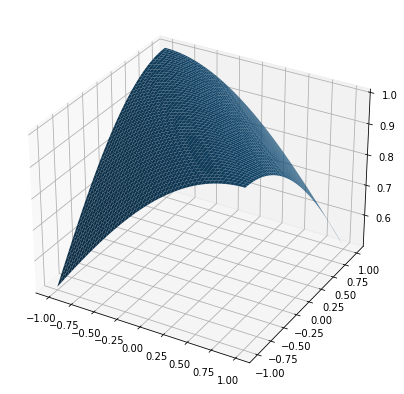

In [51]:
# diagonal motion blur
G, H = add_diagonal_blur(F)
# additive noise
GN = add_gaussian_noise(G)

Display (1) image degraded by motion blur,(2) by motion blur and additive noise

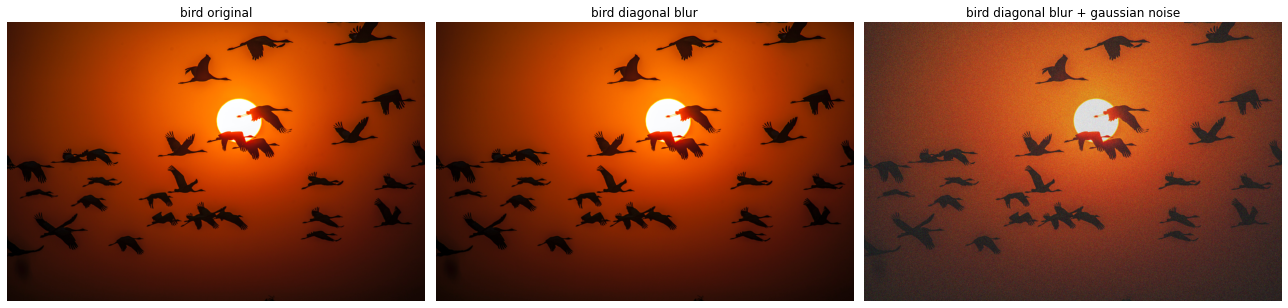

In [52]:
show_images("bird", [F, G, GN], ["original", "diagonal blur", "diagonal blur + gaussian noise"])

## Remove noise
Assume you know H(u,v)

In [53]:
def apply_inverse_filter(g, h):
    # function to apply inverse filtering for motion blur
    r = zeros(g.shape,int)             # out image
    h[abs(h)  <= 1e-2] = 1e-2          # in order to avoid division by zero

    for k in range(0,g.shape[2]):      # loop through colors channels
        c = g[:,:,k].astype(int)       # take color slice
        fc = fftshift(fft2(c))         # gather ft and shift to center
        fb = divide(fc,h)              # inverse operation of the application of this filter
        ifb = ifft2(ifftshift(fb))     # inverse ft
        r[:,:,k] = abs(ifb)            # back to spatial domain

    return r

#### Applying **inverse filter** $ h^{-1} $ on $ G $ .

$ G^{'} = \frac{G(u,v)}{H(u,v)} $

1. $ G $ is the image after **motion blur**
2. $ G $ is the image after **motion blur** and **additive noise**

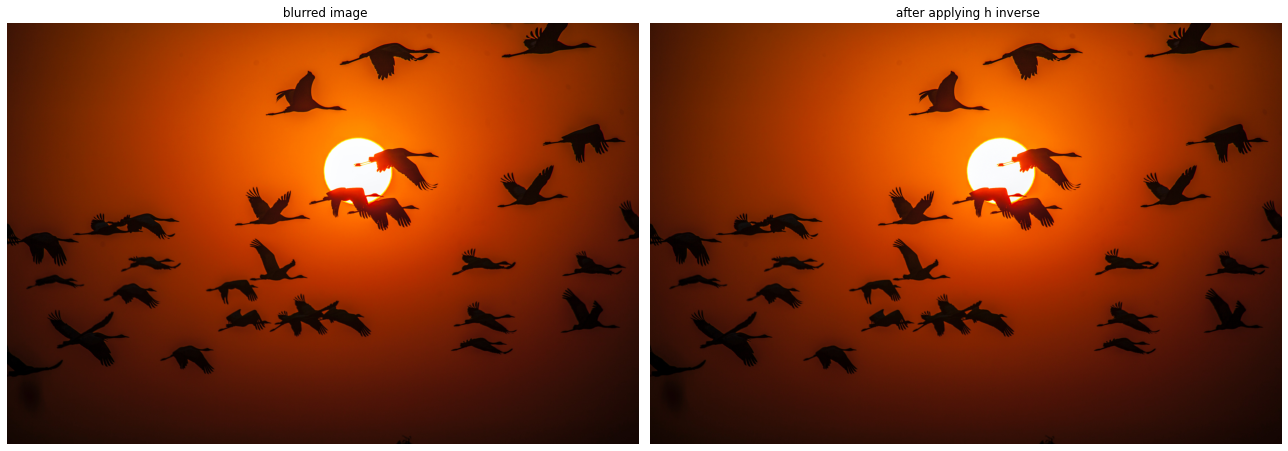

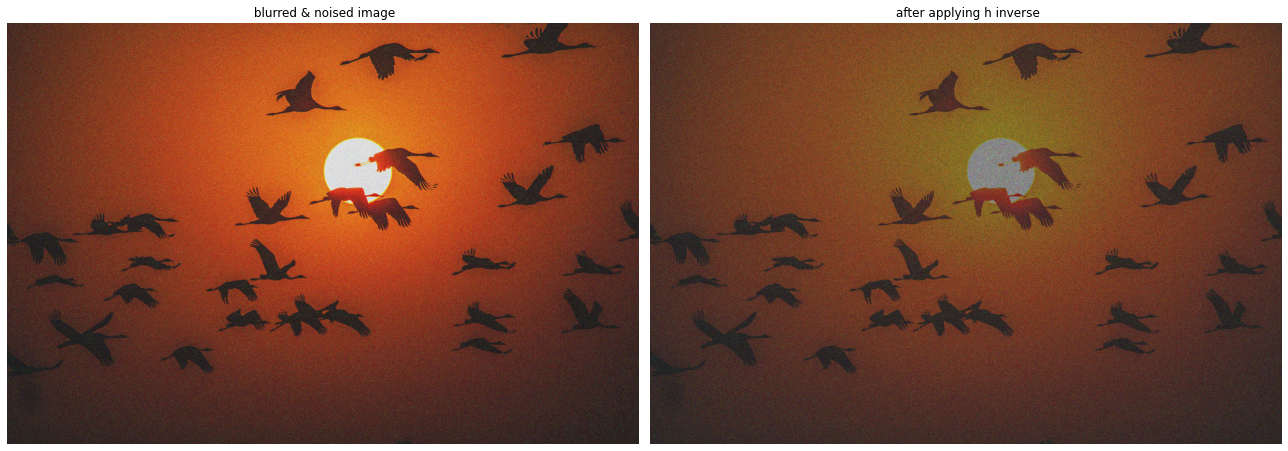

In [54]:
G_ = apply_inverse_filter(G, H)        # 1  motion blurred image
G_N = apply_inverse_filter(GN, H)      # 2  motion blurred and noised image
# showing images
show_images("", [G, G_], ["blurred image", "after applying h inverse"])
show_images("", [GN, G_N], ["blurred & noised image", "after applying h inverse"])

#### Write the equation for the **MMSE** filter $ H_w (u,v) $ when there is only additive noise

In [55]:
def mmse_filter_noise(f, fn):
    r = zeros(f.shape, int)          # out image
    n = fn-f                         # noise by difference between noised image & original image
    for k in range(0,f.shape[2]):
        fs = abs(fftshift(fft2(f[:,:,k]))) ** 2         # original image power spectrum
        ns = abs(fftshift(fft2(n[:,:,k]))) ** 2         # noise power spectrum
        fns = fftshift(fft2(fn[:,:,k]))                 # noised image tf
                            # assume h = 1 then
        hw = 1 / (1 + (ns/fs))                          # filter h function
        fr = fns * hw                                   # apply filter in fourier domain
        ifr = ifft2(ifftshift(fr))                      # inverse tf
        r[:,:,k] = abs(ifr)                             # back to spatial domain

    return r

#### Apply this **MMSE** filter $ H_w (u,v) $

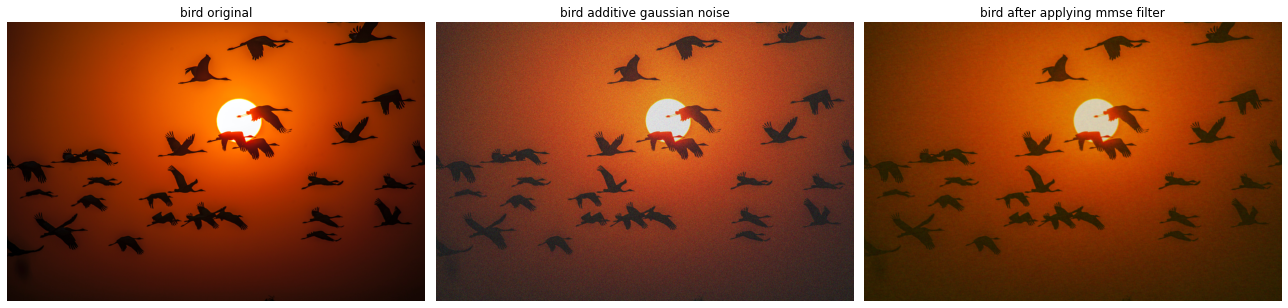

In [56]:
FN = add_gaussian_noise(F)          # only additive noise asked (could have used the restored image but im recycling the function)
FN_ = mmse_filter_noise(F, FN)            # we get back FN_ which is the restored image and N which is the noise
# showing images
show_images("bird", [F,FN, FN_], ["original","additive gaussian noise", "after applying mmse filter"])

#### Write the equation for the **MMSE** filter $ H_w $ when there motion blur and additive noise
Approximate the ratio of the noise power spectrum to original image power spectrum by a constant $ K = \frac{S_{nn}(u,v)}{S_{ff}(u,v)} $

Calculate $ K $ from the average of their true ratio

In [57]:
def mmse_filter_complete(f, h, g):
    r = zeros(f.shape, int)     # out image
    n = g-f                     # noise estimation by difference with original image

    for j in range(0, f.shape[2]):                   # loop through color layers
        fs = abs(fftshift(fft2(f[:,:, j]))) ** 2     # original image power spectrum
        ns = abs(fftshift(fft2(n[:,:, j]))) ** 2     # noise power spectrum
        _k = ns / fs                                # k - power spectrum ratio
        dh = abs(h) ** 2 + _k                       # wiener filter den
        hw = conj(h) / dh                           # filter h function
        gs = fftshift(fft2(g[:,:, j]))               # tf of the noised image
        fr = gs * hw                                # apply filter in frequency domain
        ifr = ifft2(ifftshift(fr))                  # inverse tf
        r[:,:, j] = abs(ifr)                         # back to spatial domain

    return r

#### Apply the resulting **MMSE** filter $ H_w $ to the image
after it has undergone motion blur and additive noise

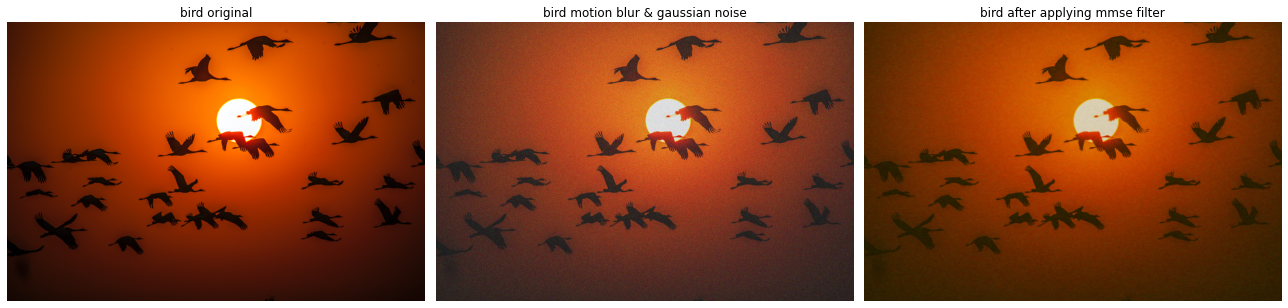

In [58]:
GN_ = mmse_filter_complete(F, H, GN)
show_images("bird", [F,GN, GN_], ["original","motion blur & gaussian noise", "after applying mmse filter"])

# 2. Hiding secret message in DCT

In [59]:
def dct2(a):
    # 2-D DCT tf
    return dct(dct(a.T, norm='ortho').T, norm='ortho')
def idct2(a):
    # 2-D DCT inverse tf
    return idct(idct(a.T, norm='ortho').T, norm='ortho')
def find_dct_blocks(img):
    # extract 8x8 2-D DCT coefficients
    dct_blocks = zeros(img.shape)            # out shape
    for i in r_[:img.shape[0]:8]:            # block-wise dct
        for j in r_[:img.shape[1]:8]:
            dct_blocks[i:i + 8, j:j + 8] = dct2(img[i:i + 8,j:j + 8])

    return dct_blocks
def k_largest_values(a, K):
    # stretch the array
    # sort by values and gather indexes
    # gather last K indexes from sorted array
    # reshape indexes and gather values from them
    return c_[unravel_index(argpartition(a.ravel(),-K)[-K:],a.shape)]
def find_best_k_dct(_dct, img, debug=False):
    size = img.shape
    _k_dct = None           # out params
    _k_idx = None
    _k = -1

    for K in range(1250,950,-50):              # testing range
        k_idct = zeros(size)                    # out image
        idx = k_largest_values(_dct, K)         # indexes of highest K coefficients
        filtered = zeros(_dct.shape)            # out K coefficients
        filtered[idx] = _dct[idx]               # gather the coefficients from indexes

        for i in r_[:size[0]:8]:                # block-wise idct from filtered coefficients
            for j in r_[:size[1]:8]:
                k_idct[i:(i+8),j:(j+8)] = idct2(filtered[i:(i+8),j:(j+8)] )

        if debug:                               # some debug
            figure()
            imshow(hstack( (img, k_idct) ) ,cmap='gray')
            title(str("Comparison between original and %d dct blocks" %K ))

        if K == 1100 :                           # best one found by inspection
            _k = K                               # store out params
            _k_dct = k_idct
            _k_idx = idx

    return _k, _k_dct, _k_idx
def fill_gaussian(a,idx,K,s,):
    # generate K random numbers from gaussian distribution with mean 0 and var s
    gaussian = normal(0,s,K)
    m,n = zip(*idx)         # get indexes
    a[m,n] = gaussian       # add gaussian noise
    return a
def insert_watermark(img, c, idx, s, a, debug=False):
    # embed watermark from K largest non-DC DCT coefficients
    _wk = zeros(k_dct.shape)            # pseudo-random W_k's
    _wk = fill_gaussian(_wk,idx,k,s)    # from gaussian

    # _wk[0,0] = 0
    # hist(_wk), show()

    marked = c * (1 + a * _wk)          # embed watermark in K-highest coefficients
    i_marked = zeros(sz)                # out image
    for i in r_[:sz[0]:8]:              # block-wise idct
        for j in r_[:sz[1]:8]:
            i_marked[i:(i+8),j:(j+8)] = idct2(marked[i:(i+8),j:(j+8)])

    diff = img-i_marked                 # gather difference

    if debug:                           # some debug + display asked
        print("\nTesting sigma=%f , alpha=%f \n" %(s,a))
        figure(figsize=figure_size)
        subplot(2,2,1), axis("off"), title("Original") , imshow(img, cmap='gray')                  # the original image
        subplot(2,2,2), axis("off"), title("Image with watermark") , imshow(i_marked, cmap='gray') # the watermarked image
        subplot(2,2,3), axis("off"), title("Difference image") , imshow(diff, cmap='gray')         # the difference image
        subplot(2,2,4), title("histogram difference") , hist(diff)                                 # the histogram of the difference image
        show()

    return i_marked, _wk

## 2.1 Watermark insertion
Chose a *_grayscale_* image to which will insert a watermark

##### Compute the 2-D DCT of the image in a block-wise manner.

In [60]:
image = load("cameraman", 0)
sz = image.shape
_dct = find_dct_blocks(image)

##### Choose its $ K $ coefficients, $ c_1 , c_2 ,..., c_K $
with the largest magnitude, choose K such that creates an image that
still looks like the original one, just using fewer DCT coefficients

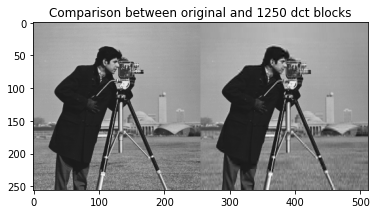

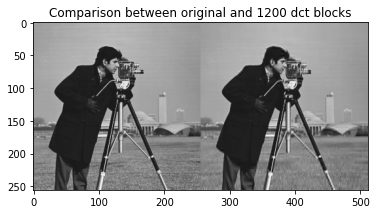

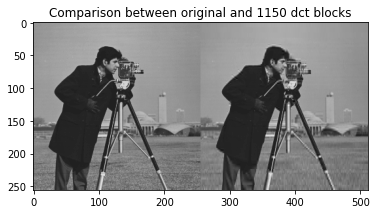

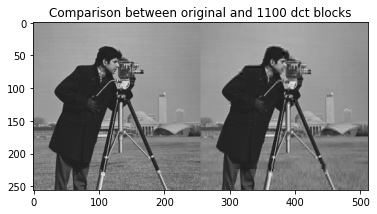

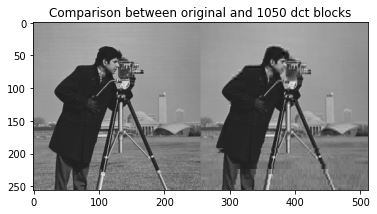

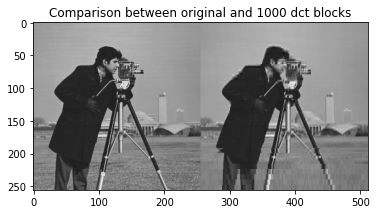

In [61]:
# testing
k, k_dct, k_idx = find_best_k_dct(_dct, image, debug=True)

##### Create a watermark by generating K-element pseudo-random numbers,
$ w_1, w_2, ..., w_K $ that follow a Gaussian distribution with mean $ \mu = 0 $ and
variance $ \sigma ^2 $ to be chosen


Testing sigma=0.010000 , alpha=0.100000 



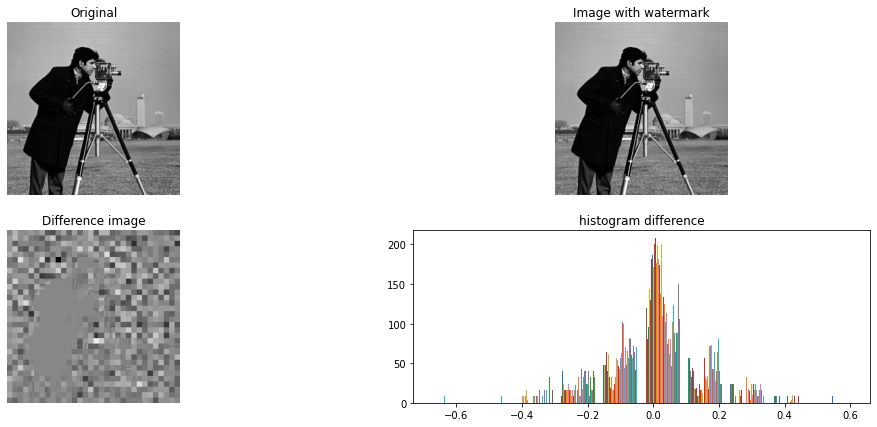


Testing sigma=0.100000 , alpha=0.100000 



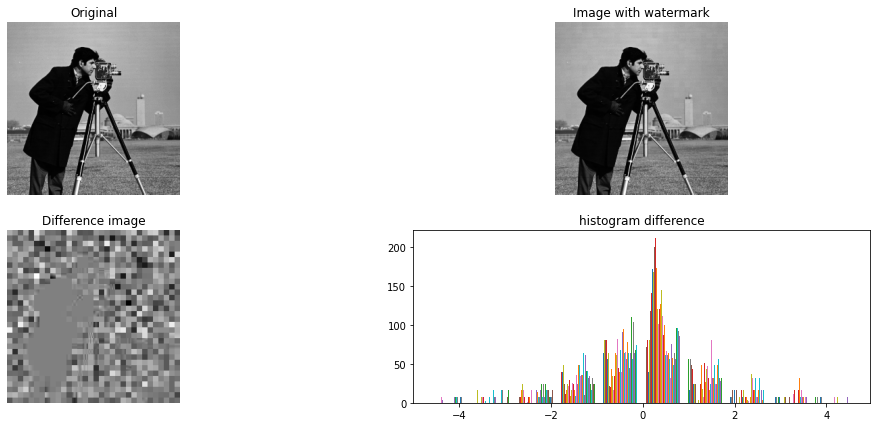


Testing sigma=0.500000 , alpha=0.100000 



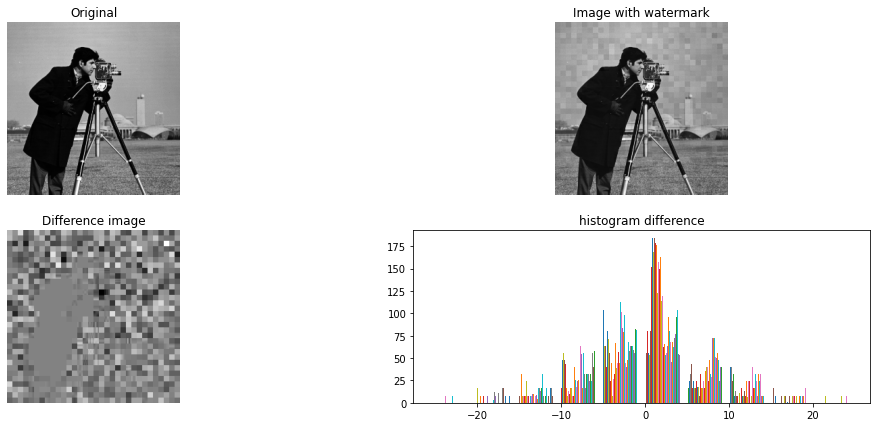


Testing sigma=0.010000 , alpha=0.250000 



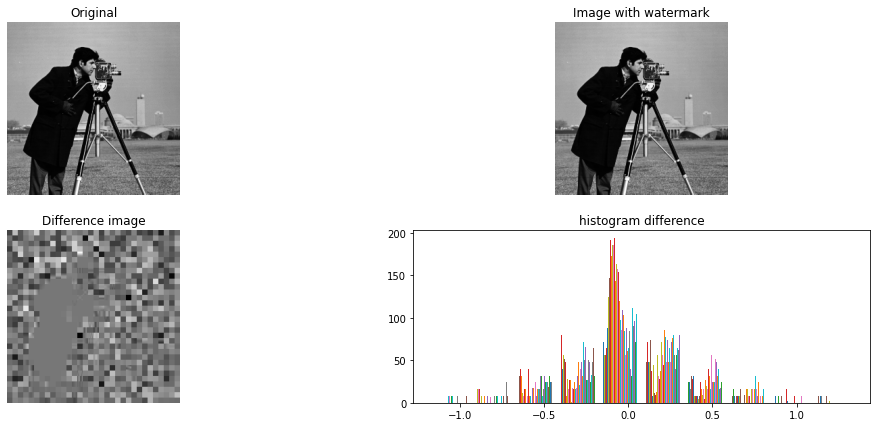


Testing sigma=0.100000 , alpha=0.250000 



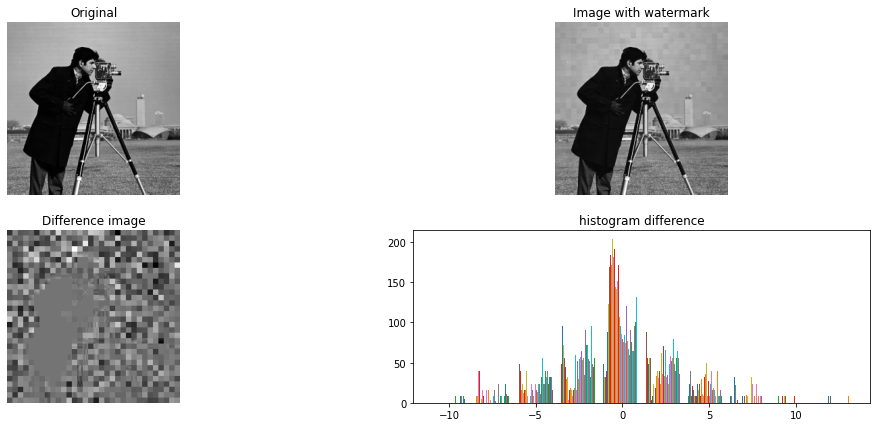


Testing sigma=0.500000 , alpha=0.250000 



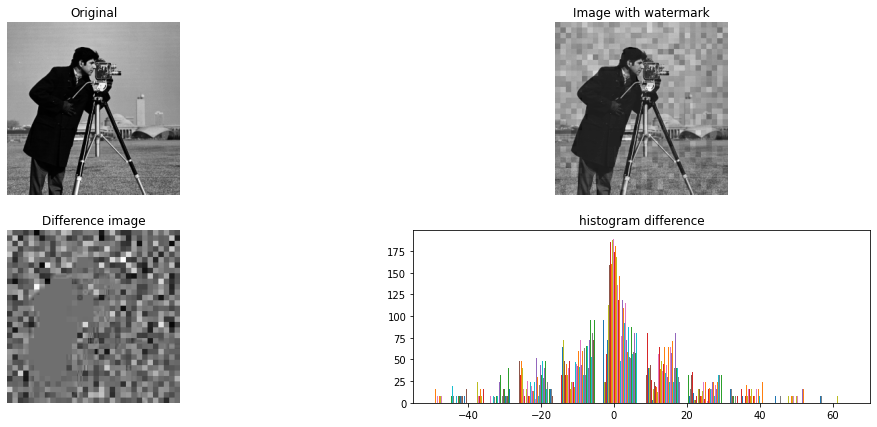


Testing sigma=0.010000 , alpha=0.500000 



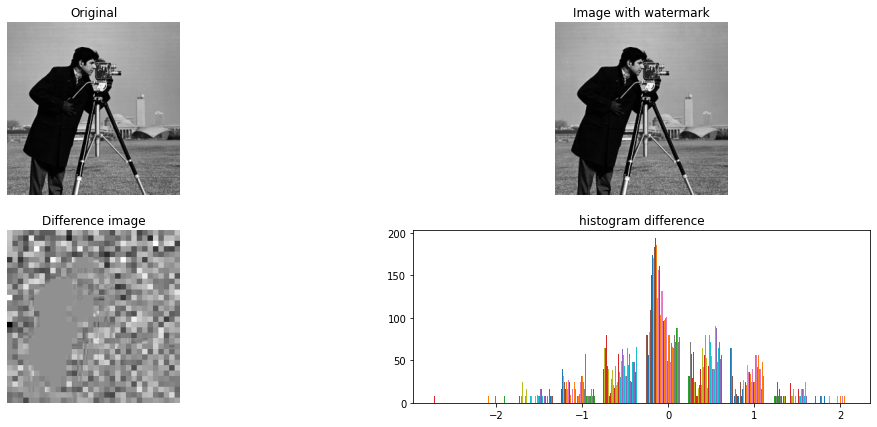


Testing sigma=0.100000 , alpha=0.500000 



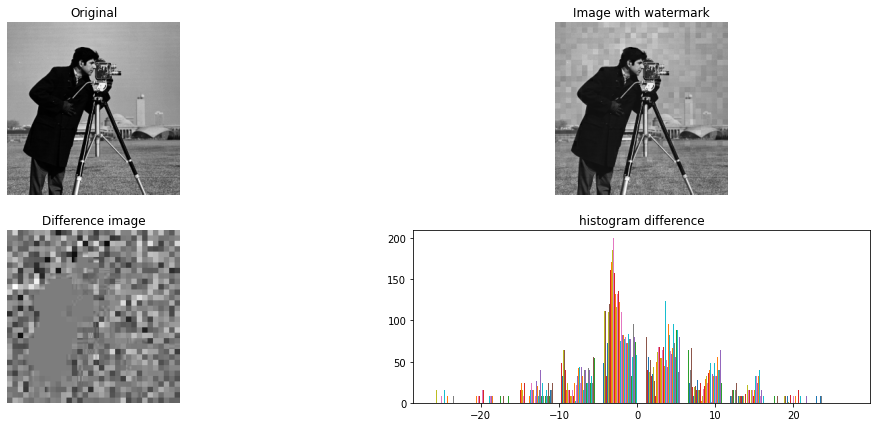


Testing sigma=0.500000 , alpha=0.500000 



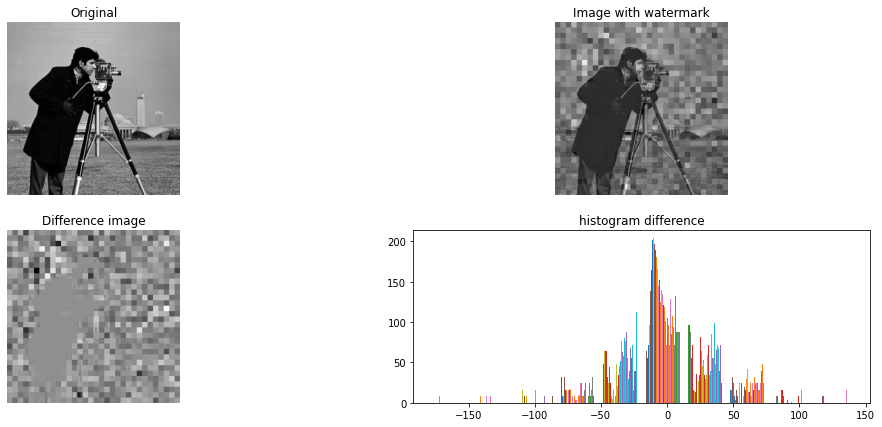

In [62]:
#testing some alpha and sigma params
for alpha in [0.1, 0.25, 0.5]:
    for sigma in [0.01, 0.1, 0.5]:
        _,_ = insert_watermark(image, _dct, k_idx, sigma, alpha, debug=True)        # set test true

##### Steps
Embed the watermark,
Create the DCT of the watermarked image,
Compute the inverse DCT of the DCT with the new coefficients $ c^{'}_i $ ,
Display the original, the watermarked, their difference image
(explained where the code is)

In [63]:
# keeping watermarked image with :
sigma = 0.25
alpha = 0.1
marked_image, wk = insert_watermark(image, _dct, k_idx, sigma, alpha)     # gather marked image and w_k

##### Explain results




##### Explain why you do not put a watermark on the DC coefficients





## 2.2 Watermark Detection

In [64]:
def correlation_coefficient(wi, wi_hat):
    wi_mean = mean(wi); wi_hat_mean = mean(wi_hat)      # mean original wi, mistery wi
    num = sum((wi_hat - wi_hat_mean) * (wi - wi_mean))  # numerator
    den1 = sum((wi_hat - wi_hat_mean) ** 2)
    den2 = sum((wi - wi_mean) ** 2)
    den = sqrt(den1 * den2)                             # denominator
    gamma = nan if den == 0 else  num / den             # avoid / 0 place nan directly
    D = 1 if gamma > 0 else 0                           # threshold
    watermark = D == 1                                  # D == 1 , watermark is present
    return gamma, D, watermark
def estimate_watermark(m):
    # detect if the mistery image m has a watermark
    m_dct = find_dct_blocks(m)                      # compute 2-D DCT coefficients
    m_k_idct = zeros(m.shape)                       # out dct shape
                     # C_i, alpha, K are known from before
    K = 1100
    m_k_idx = k_largest_values(m_dct, K)            # filter K largest non-DC DCT coefficients indexes
    filtered = zeros(m_dct.shape)                   # out filtered coefficients
    filtered[m_k_idx] = m_dct[m_k_idx]              # place coefficients at the K indexes

    for i in r_[:sz[0]:8]:                          # block-wise inverse 2-D DCT tf
        for j in r_[:sz[1]:8]:
            m_k_idct[i:(i+8),j:(j+8)] = idct2(filtered[i:(i+8),j:(j+8)] )

    _wk = zeros(m_k_idct.shape)                     # out w_ks
    _wk = fill_gaussian(_wk,m_k_idx,k,sigma)        # add gaussian noise from known distribution

                    # C^_i - C_i / alpha * C_i
    wk_hat = (m_k_idct - k_dct) / (alpha * k_dct)   # estimate approximation of the watermark
    # measure the similarity of the coefficients
    gamma, D, watermark = correlation_coefficient(_wk, wk_hat) # compare similarity with threshold
    print("Does the image contain watermark ? %s" % watermark) # return whether watermark is present
    return watermark

You will be given a mistery image, and you will have to find if it is watermarked, comparing it with the known image.
Consider 2 Cases

#### Mistery image is the watermarked image

In [65]:
mistery1 = marked_image
marked1 = estimate_watermark(mistery1)

Does the image contain watermark ? False


#### Mistery image is the original image

In [66]:
mistery2 = image
marked2 = estimate_watermark(image)

Does the image contain watermark ? False


#### Show and explain results

In [67]:
print(marked1, marked2)




False False


# 3. Morphology
## 3.1 Count oranges
Choose 2 images,
Convert them into black and white, by an empirically determined threshold to binarize them

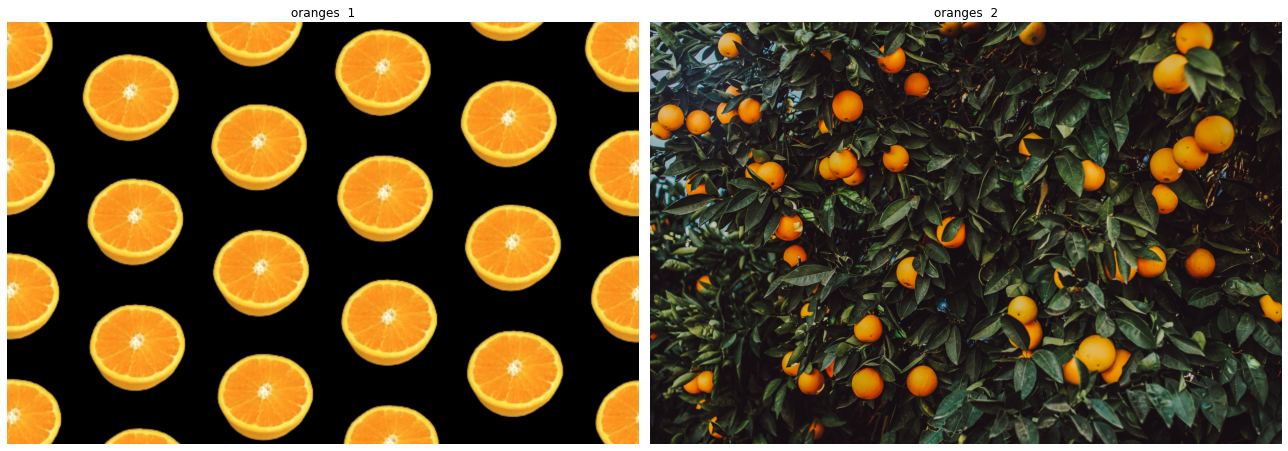

In [68]:
image1 = rgb(load("oranges"))
image2 = rgb(load("orangetree"))
show_images("oranges",[image1,image2],[" 1", " 2"])

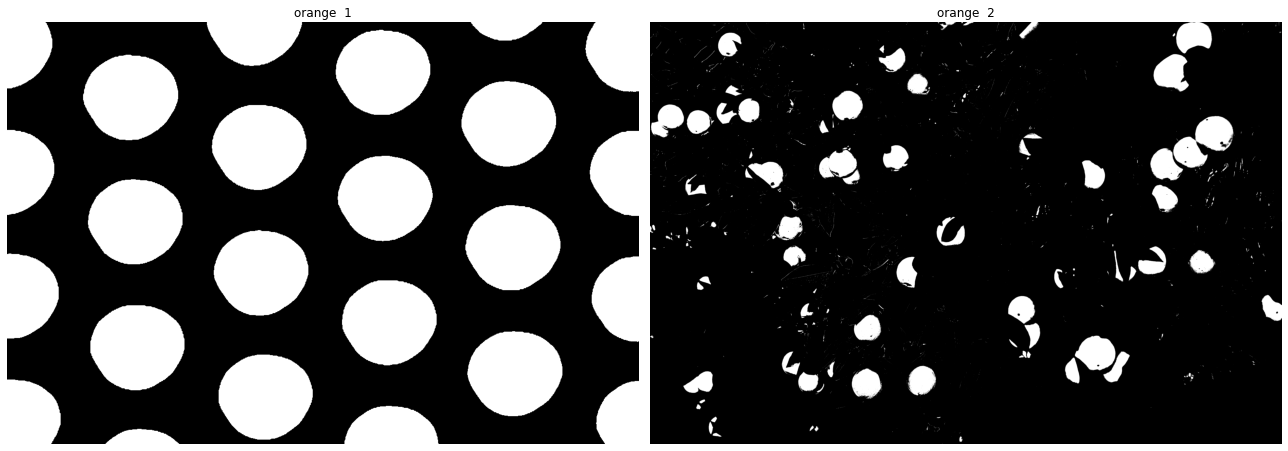

In [69]:
# empirical threshold -> (red > threshold)
threshold = 180
orange1 = binarize(image1,threshold=threshold)
orange2 = binarize(image2,threshold=threshold)
show_images("orange",[orange1,orange2],[" 1", " 2"],['gray','gray'])

#### Count the number of oranges in the 2 images.
#### Explain intermediate steps and results.

In [70]:
# here i created this basic procedure to evaluate the sizes of the needed
# se components for each image, to then use that for the counting procedure
# and the frequency finding :
# given a range r, which determines the sizes to test the SE with,
# start from the lowest size, and increase it gradually,
# find where the size increase leads to an huge difference in the area sum
# this means the element with given size is obstructing all objects in the image
# hence we have found the size we need
def morphological_open(img, j, dtype=uint8, debug=False):
    # perform morphological opening operation
    img = img.astype(dtype)                                     # convert image to type needed
    kernel = getStructuringElement(MORPH_ELLIPSE, (j, j))       # generate structuring element of given size
    eroded = erode(img,kernel)                                  # perform erosion to smooth out edges
    dilated = dilate(eroded, kernel)                            # perform dilatation to enhance bodies radius
    pix_sum1 = countNonZero(dilated)                            # gather area sum  b&w
    pix_sum2 = sum(dilated)                                     # gather area sum  grayscale
    diff = subtract(img,dilated)                                # gather difference image

    if debug:                                                   # visualize:
        subplot(1,3,1), axis('off'), title('orig'), imshow(img,'gray')          # original image
        subplot(1,3,2), axis('off'), title('eroded'), imshow(eroded,'gray')     # eroded image
        subplot(1,3,3), axis('off'), title('dilated'), imshow(dilated,'gray')   # dilated image
        show()

    return eroded, dilated, pix_sum1, pix_sum2, diff
def morphological_close(img, j, dtype=uint8, debug=False):
    # perform morphological closing operation
    img = img.astype(dtype)                                     # convert image to type needed
    kernel = getStructuringElement(MORPH_ELLIPSE, (j, j))       # generate structuring element of given size
    dilated = dilate(img, kernel)                               # perform dilatation to enhance bodies radius
    eroded = erode(dilated,kernel)                              # perform erosion to smooth out edges
    pix_sum1 = countNonZero(dilated)                            # gather area sum b&w
    pix_sum2 = sum(dilated)                                     # gather area sum grayscale
    diff = subtract(img,dilated)                                # gather difference image

    if debug:                                                   # visualize:
        subplot(1,3,1), axis('off'), title('orig'), imshow(img,'gray')          # original image
        subplot(1,3,2), axis('off'), title('eroded'), imshow(eroded,'gray')     # eroded image
        subplot(1,3,3), axis('off'), title('dilated'), imshow(dilated,'gray')   # dilated image
        show()

    return eroded, dilated, pix_sum1, pix_sum2, diff
def test_se_sizes(bw_img,r,dtype=uint8,debug=False):
    bw_img = bw_img.astype(dtype)
    sums1 = [];sums2 = []; diffs1 = [];diffs2 = []; sizes = []                              # out params
    for i in range(0,len(r)):
        sizes.append(r[i])                                         # testing SE size r[i]
        _,_,s1,s2,_ = morphological_open(bw_img,r[i],dtype,debug)  # apply open morphological operation to better separate distinct objects
        sums1.append(s1)                                           # collect surface area of the opened image b&w
        sums2.append(s2)                                           # collect surface area of the opened image grayscale

    for i in range(0,len(sums1)-1):                                # area difference between sums adjacent elements collected
        diffs1.append(abs(sums1[i]-sums1[i+1]))                    # b&w
        diffs2.append(abs(sums2[i]-sums2[i+1]))                    # grayscale

    return sizes, diffs1, diffs2

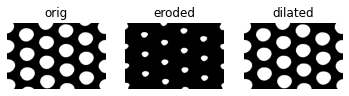

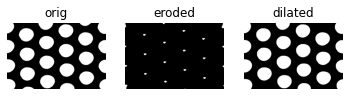

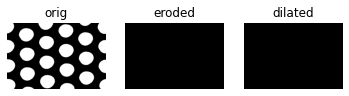

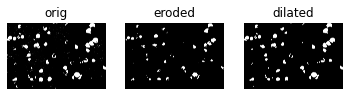

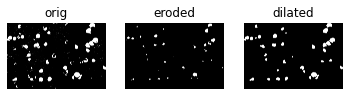

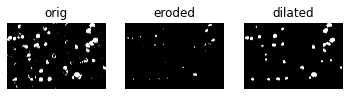

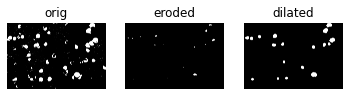

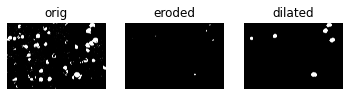

In [71]:
_,_,_ = test_se_sizes(orange1,r = range(100,250,50), debug=True)                        # showing some images of erosion/dilation
_,_,_ = test_se_sizes(orange2,r = range(50,300,50), debug=True)

In [72]:
sizes1, diff1,_ = test_se_sizes(orange1,r = range(150,200,2))              # more detailed analysis on closer steps in range
sizes2, diff2,_ = test_se_sizes(orange2,r = range(100,300,10))             # store differences & don't show images

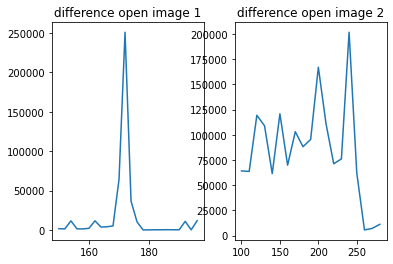

In [73]:
# show plot of differences
subplot(1,2,1), title("difference open image 1"), plot(sizes1[:-1], diff1)
subplot(1,2,2), title("difference open image 2"), plot(sizes2[:-1], diff2)
show()

As we can see from the plots, the peaks in the function given by the procedure above described will
represent the point in which changing the size of the SE component used for the analysis, leads to a drastic
reduction in the number of object restored after applying erosion, and then dilation.

This is indicating that the SE size being used, exceeds the size of the objects we are trying to identify,
and therefore, these gets depleted by erosion, without any chance for dilation to recover them, e.g.

Assume that starting with SE size $ S = X1 $ , we can still see all the objects in the image after open morphological operation.
Then let $ X2 = X + k $  where $ k > 0 $,
Assume that using $ S = X2 $ we can't see anymore the objects in the image after open morphological operation,
Then it means that the objects we are looking for have size $ X1 < Sx < X2 $

Hence, by subtracting the surface area generated by the opened image and making a ratio between the different
sizes tested, will give us the distribution of the object sizes in the image, at which we can then look
to see where these differences where higher.

Of course, due to not all oranges having the same size in both images, the spikes in the graph
will be multiple ones, and they will be higher when the more of the objects will be filtered at that size.
This factor is much more highlighted in the second picture analysis, due to the oranges hidden by the leaves


In [74]:
def count_objects(img, se):
    img = img.astype(uint8)             # reformat
    d = erode(img,se)                   # apply erosion to remove small components
    e = dilate(d, se)                   # apply dilatation to enhance the objects pixels
    ret,_ = connectedComponents(e)      # label clustered pixel and count objects
    count = ret-1                       # background is a connected component so take count-1

    # debug
    # subplot(1,3,1), axis('off'), title('image'), imshow(img,'gray')
    # subplot(1,3,2), axis('off'), title('dilated'), imshow(d,'gray')
    # subplot(1,3,3), axis('off'), title('eroded'), imshow(e,'gray')
    # show()
    return count
def count_objects_1():
    # found out minimum size of the oranges is approx 155
    # but the complete elliptical shaped ones have diam 175,
    # therefore the number of counted objects may vary depending from
    # the chosen SE size
    min_size_1 = getStructuringElement(MORPH_ELLIPSE, (155,155))                # this gives pretty much all oranges
    # standard_size_1 = getStructuringElement(MORPH_ELLIPSE, (175,175))         # this gives pretty much all fully drawn oranges
    r = count_objects(orange1, min_size_1)
    print('Image 1 : Found %f oranges' %r)

    return
def count_objects_2():
    # as described above, due to the hidden oranges there are some minor peaks and some major ones
    minor = [120,150,175]                                       # testing minor peaks
    major = [200,240]                                           # testing major peaks
    min_sum = 0; maj_sum = 0
    for mi in minor:
        se = getStructuringElement(MORPH_ELLIPSE, (mi,mi))      # create structuring element of test size
        min_sum += count_objects(orange2,se)                    # count number of objects with test size

    for ma in major:
        se = getStructuringElement(MORPH_ELLIPSE, (ma,ma))      # create structuring element of test size
        maj_sum += count_objects(orange2,se)                    # count number of objects with test size

    min_avg = min_sum / len(minor)                              # average by the number of peaks found
    maj_avg = maj_sum / len(major)

    print("Image 2 : Found %f minor sized oranges,  %f major sized oranges" %(min_avg, maj_avg))
    # very indicative, it's not true that the min avg represent the small oranges, but
    return

In [75]:
count_objects_1()
count_objects_2()

Image 1 : Found 22.000000 oranges
Image 2 : Found 27.666667 minor sized oranges,  14.000000 major sized oranges


#### Explain results




## 3.2 Granulometry
Choose 2 images,
Convert them into *_grayscale_*

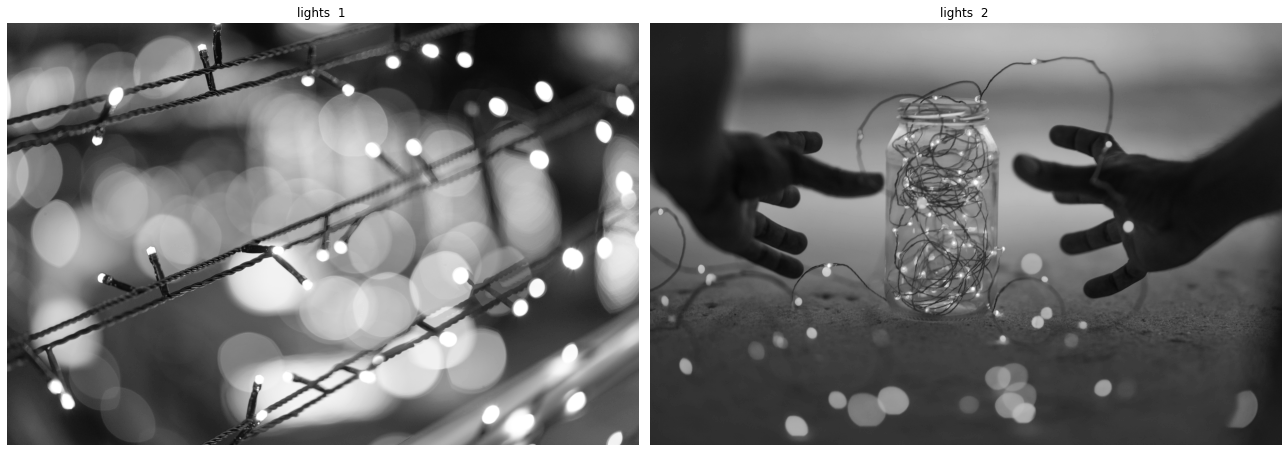

In [76]:
light1 = gray(load('lights'))
light2 = gray(load('jar'))
show_images("lights",[light1,light2],[" 1 ", " 2 "],['gray','gray'])

Find the frequency of the different sized lights that appear in the images
Explain intermediate steps


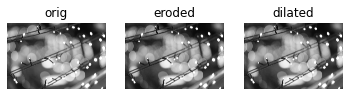

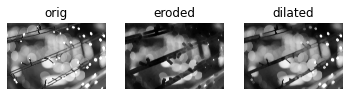

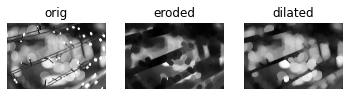

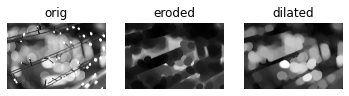

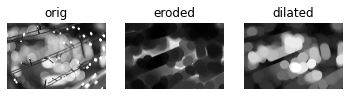

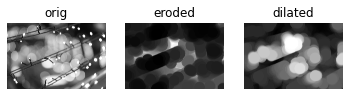

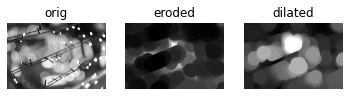

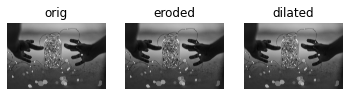

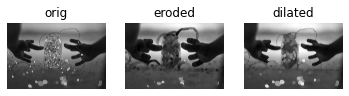

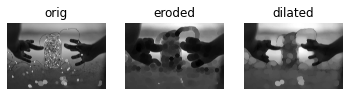

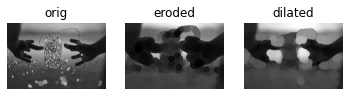

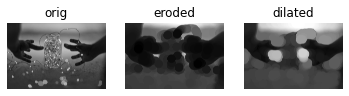

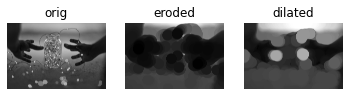

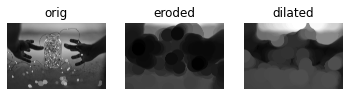

In [77]:
_,_,_ = test_se_sizes(light1,r = range(5,800,125), debug=True)
_,_,_ = test_se_sizes(light2,r = range(5,800,125), debug=True)

In [78]:
sizes1,_, diff1 = test_se_sizes(light1,r = range(5,800,25))
sizes2,_, diff2 = test_se_sizes(light2,r = range(5,800,25))

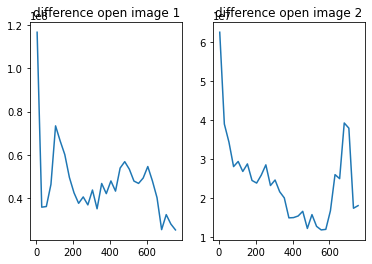

In [79]:
# show plot of differences
subplot(1,2,1), title("difference open image 1"), plot(sizes1[:-1], diff1)
subplot(1,2,2), title("difference open image 2"), plot(sizes2[:-1], diff2)
show()

Explain results






## PCA - Recognition